In [1]:
import copy
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import ray
import time


from bisect import bisect_left, bisect_right, bisect
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from ray.util.multiprocessing import Pool
from scipy.signal import find_peaks_cwt
from tqdm.auto import tqdm


numberCPUS = 24


In [2]:
#Ray actor for holding global progress in parallel operations
@ray.remote(num_cpus=0)
class SamplingProgress_Actor:
    def __init__(self): self.current = 0.0
    def update(self, amount): self.current += amount
    def getCurrent(self): return self.current
    
def convertData(scanFileName, i, x, y, z, samplingProgress_Actor):
    data = ImzMLParser(scanFileName)
    mzs, ints = data.getspectrum(i)
    if data.spectrum_mode == 'profile':
        peakLocations = find_peaks_cwt(ints, np.arange(1,30), min_snr=3.0)
        mzs, ints = mzs[peakLocations], ints[peakLocations]
    del data
    _ = ray.get(samplingProgress_Actor.update.remote(1))
    return mzs, ints, x, y, z


In [3]:
sampleFolders = glob.glob('./INPUT_MALDI/TRAIN/*')+ glob.glob('./INPUT_MALDI/TEST/*')
sampleNames = [os.path.basename(sampleFolder) for sampleFolder in sampleFolders]
scanFileNames = [sampleFolder+os.path.sep+sampleNames[index]+'.imzML' for index, sampleFolder in enumerate(sampleFolders)]

for index, scanFileName in tqdm(enumerate(scanFileNames), total=len(scanFileNames), desc='Samples', leave=True):
    
    #Establish file pointer for the single imzML file
    data = ImzMLParser(scanFileName)
    
    if data.intensityPrecision == 'f': intensity_dtype = np.float32
    elif data.intensityPrecision == 'd': intensity_dtype = np.float64
    else: sys.exit('\nError - Unknown intensity precision type')
    if data.mzPrecision == 'f': mz_dtype = np.float32
    elif data.mzPrecision == 'd': mz_dtype = np.float64
    else: sys.exit('\nError - Unknown mz precision type')
    
    #Get array of coordinates (do not change positions!)
    coordinates = np.asarray(data.coordinates)
    maxProgress = len(coordinates)
    
    #Close the file pointer
    del data
    
    #Setup an actor to hold global sampling progress across multiple processes
    samplingProgress_Actor = SamplingProgress_Actor.remote()

    #Centroid spectra at all locations
    pbar = tqdm(total=maxProgress, desc='% Complete', leave=True)
    computePool = Pool(numberCPUS)
    futures = [(scanFileName, i, x, y, z, samplingProgress_Actor) for i, (x, y, z) in enumerate(coordinates)]
    results = computePool.starmap_async(convertData, futures)
    computePool.close()

    #While some results have yet to be returned, regularly update the global progress bar, then obtain results and purge/reset ray
    pbar.n = 0
    pbar.refresh()
    while (True):
        pbar.n = np.clip(round(copy.deepcopy(ray.get(samplingProgress_Actor.getCurrent.remote())),2), 0, maxProgress)
        pbar.refresh()
        if results.ready(): 
            pbar.n = maxProgress
            pbar.refresh()
            pbar.close()
            break
        time.sleep(0.1)
    computePool.join()
    results = results.get().copy()
    
    #Write results to a new imzML file
    newSampleName = sampleNames[index]+'.imzML'
    writer = ImzMLWriter(newSampleName, intensity_dtype=intensity_dtype, mz_dtype=mz_dtype, spec_type='centroid', mode='processed')
    for mzs, ints, x, y, z in results: writer.addSpectrum(mzs, ints, (x, y, z))
    writer.close()
    


Samples:   0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
2025-05-04 23:54:42,746	INFO worker.py:1772 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


% Complete:   0%|          | 0/34599 [00:00<?, ?it/s]

(PoolActor pid=37276) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
(PoolActor pid=37276)   warn(
C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


% Complete:   0%|          | 0/30276 [00:00<?, ?it/s]

(PoolActor pid=2456) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)". [repeated 24x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(PoolActor pid=2456)   warn( [repeated 24x across cluster]


% Complete:   0%|          | 0/32988 [00:00<?, ?it/s]

(PoolActor pid=67360) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)". [repeated 24x across cluster]
(PoolActor pid=67360)   warn( [repeated 24x across cluster]


% Complete:   0%|          | 0/39576 [00:00<?, ?it/s]

(PoolActor pid=83616) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)". [repeated 24x across cluster]
(PoolActor pid=83616)   warn( [repeated 24x across cluster]


% Complete:   0%|          | 0/15862 [00:00<?, ?it/s]

(PoolActor pid=56380) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)". [repeated 24x across cluster]
(PoolActor pid=56380)   warn( [repeated 24x across cluster]


% Complete:   0%|          | 0/19272 [00:00<?, ?it/s]

(PoolActor pid=33024) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)". [repeated 24x across cluster]
(PoolActor pid=33024)   warn( [repeated 24x across cluster]


% Complete:   0%|          | 0/23465 [00:00<?, ?it/s]

(PoolActor pid=65872) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)". [repeated 24x across cluster]
(PoolActor pid=65872)   warn( [repeated 24x across cluster]


% Complete:   0%|          | 0/21287 [00:00<?, ?it/s]

(PoolActor pid=39268) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)". [repeated 24x across cluster]
(PoolActor pid=39268)   warn( [repeated 24x across cluster]


% Complete:   0%|          | 0/17412 [00:00<?, ?it/s]

(PoolActor pid=56016) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)". [repeated 24x across cluster]
(PoolActor pid=56016)   warn( [repeated 24x across cluster]


% Complete:   0%|          | 0/25406 [00:00<?, ?it/s]

(PoolActor pid=14172) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)". [repeated 24x across cluster]
(PoolActor pid=14172)   warn( [repeated 24x across cluster]


% Complete:   0%|          | 0/32618 [00:00<?, ?it/s]

(PoolActor pid=50172) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)". [repeated 24x across cluster]
(PoolActor pid=50172)   warn( [repeated 24x across cluster]


% Complete:   0%|          | 0/16111 [00:00<?, ?it/s]

(PoolActor pid=62412) C:\Users\Yatagarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)". [repeated 24x across cluster]
(PoolActor pid=62412)   warn( [repeated 24x across cluster]


In [155]:
1000495/976.448

1024.6270154683095

In [220]:
mzValue = 976.448
ppm = 200/1e6
ppmPos, ppmNeg = 1+ppm, 1-ppm
mzLower, mzUpper = mzValue*ppmNeg, mzValue*ppmPos

In [221]:
len(coordinates)

17412

Locations:   0%|          | 0/17412 [00:00<?, ?it/s]

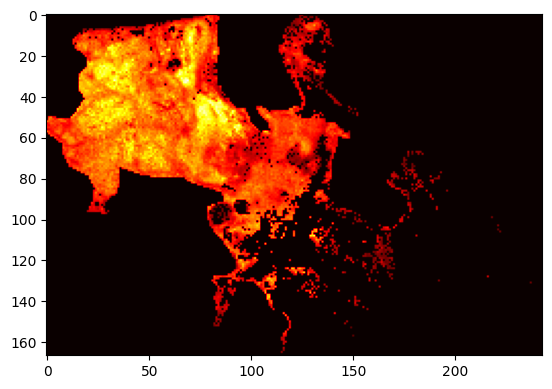

MAX:  11.29800033569336


In [222]:
data = ImzMLParser('ap43_tr_p4b_b.imzML')
coordinates = np.asarray(data.coordinates)

mzImage = np.zeros((coordinates[:,1].max()+1, coordinates[:,0].max()+1))

for i, (x, y, z) in tqdm(enumerate(coordinates), total = len(coordinates), desc='Locations', leave=False):
    mzs, ints = data.getspectrum(i)
    mzImage[y, x] = np.sum(ints[bisect_left(mzs, mzLower):bisect_right(mzs, mzUpper)])
    
plt.imshow(mzImage, cmap='hot'); plt.show(); plt.close()
print('MAX: ', mzImage.max())




Locations:   0%|          | 0/17412 [00:00<?, ?it/s]

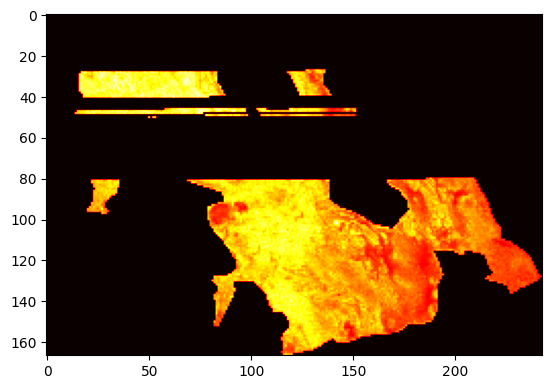

MAX:  468.5260009765625


In [207]:
data = ImzMLParser('./INPUT_MALDI_PROFILE/TEST/ap43_tr_p4b_b/ap43_tr_p4b_b.imzML')
coordinates = np.asarray(data.coordinates)-1

mzImage = np.zeros((coordinates[:,1].max()+1, coordinates[:,0].max()+1))

for i, (x, y, z) in tqdm(enumerate(coordinates), total = len(coordinates), desc='Locations', leave=False):
    mzs, ints = data.getspectrum(i)
    mzImage[y, x] = np.sum(ints[bisect_left(mzs, mzLower):bisect_right(mzs, mzUpper)])
    if y == 50 and x == 50: break
    
plt.imshow(mzImage, cmap='hot'); plt.show(); plt.close()
print('MAX: ', mzImage.max())




In [208]:
#plt.plot(mzs, ints, '.'); plt.show(); plt.close()

In [209]:
ints[bisect_left(mzs, mzLower):bisect_right(mzs, mzUpper)]

array([3.97 , 4.366, 4.712, 4.326, 4.192, 4.118, 3.488, 3.338, 3.098,
       2.856, 2.69 , 2.512, 2.376, 2.35 , 2.334, 2.3  , 2.266, 2.176,
       2.012, 2.088, 2.002, 2.052, 2.206, 2.228, 2.114, 2.152, 2.   ,
       2.14 , 2.208, 2.29 , 2.368, 2.812, 3.058, 3.708, 3.884, 4.138,
       4.106, 4.254, 4.228, 3.86 , 3.382, 3.252, 2.976, 2.678, 2.58 ,
       2.382, 2.298, 2.31 , 2.294, 2.196, 2.148, 2.248, 2.202, 1.998,
       2.15 , 2.15 , 2.01 , 2.116, 2.17 , 1.98 , 2.194, 2.182, 2.252,
       2.594, 3.414, 4.566, 5.808, 6.746, 6.85 , 6.502, 6.412, 5.496,
       4.802, 4.25 , 3.732, 3.408, 3.122, 2.852, 2.69 , 2.32 , 2.442,
       2.346, 2.264, 2.246, 2.194, 2.174, 2.164, 2.2  , 2.32 , 2.278,
       2.118, 2.148, 2.13 , 2.212, 2.196, 2.366, 2.49 , 2.852, 3.4  ,
       4.108, 4.592, 4.852, 4.692, 4.742, 4.534, 4.15 , 3.716, 3.34 ,
       3.24 , 2.95 , 2.712, 2.588, 2.308, 2.242, 2.336, 2.264, 2.282,
       2.166, 2.362, 2.172, 2.134, 2.08 , 2.084, 2.228, 2.174, 2.036,
       2.124, 2.092,

In [210]:
#After centroiding the value captured no longer exists...not a peak...
#m/z alignment?!? why is this not a problem with the DESI data...
#maybe just have to accept use of profile data?!?



In [211]:
mzValue, mzLower, mzUpper


(976.448, 974.495104, 978.400896)

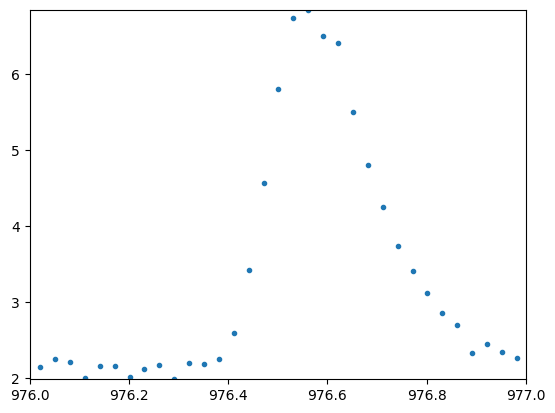

In [212]:
mzMin, mzMax = 976, 977
indices = np.logical_and(mzs>mzMin, mzs<mzMax)
mzLim, intLim = mzs[indices], ints[indices]
yLimMin, yLimMax = intLim.min(), intLim.max()
plt.plot(mzLim, intLim, '.'); plt.xlim(mzMin, mzMax); plt.ylim(yLimMin, yLimMax); plt.show(); plt.close()


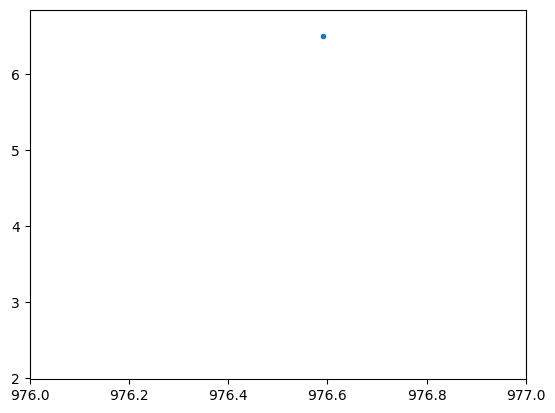

In [213]:
peakLocations = find_peaks_cwt(intLim, np.arange(1,30), min_snr=3.0)
mzNew, intNew = mzLim[peakLocations], intLim[peakLocations]

plt.plot(mzNew, intNew, '.'); plt.xlim(mzMin, mzMax); plt.ylim(yLimMin, yLimMax); plt.show(); plt.close()

In [ ]:
#Why is spectral mass alignment not an issue with the DESI data?
#
#Samples were obtained without any calibration in order to evaluate a new calibration method


In [ ]:

for index, scanFileName in tqdm(enumerate(scanFileNames), total=len(scanFileNames), desc='Samples', leave=True):
    
    #Establish file pointer for the single imzML file
    data = ImzMLParser(scanFileName)
    
    if data.intensityPrecision == 'f': intensity_dtype = np.float32
    elif data.intensityPrecision == 'd': intensity_dtype = np.float64
    else: sys.exit('\nError - Unknown intensity precision type')
    if data.mzPrecision == 'f': mz_dtype = np.float32
    elif data.mzPrecision == 'd': mz_dtype = np.float64
    else: sys.exit('\nError - Unknown mz precision type')
    
    #Create file pointer for converted imzML file
    newSampleName = sampleNames[index]+'_centroid.imzML'
    writer = ImzMLWriter(newSampleName, intensity_dtype=intensity_dtype, mz_dtype=mz_dtype, spec_type='centroid', mode='processed')

    #Adjust stored coordinates to be zero-based
    coordinates = np.asarray(data.coordinates)-1
    
    #Centroid spectra at all locations
    for i, (x, y, z) in tqdm(enumerate(coordinates), total = len(coordinates), desc='Locations', leave=False):
        mzs, ints = data.getspectrum(i)
        if data.spectrum_mode == 'profile':
            peakLocations = find_peaks_cwt(ints, np.arange(1,30), min_snr=3.0)
            mzs, ints = mzs[peakLocations], ints[peakLocations]
            writer.addSpectrum(mzs, ints, (x, y, z))
        else:
            print('Spectrum was already centroided')
            writer.addSpectrum(mzs, ints, (x, y, z))

    #Close the file pointers
    del data
    writer.close()




